## Homography with RanSaC

<p style='direction:rtl; text-align: right'>
برای محسابه هوموگرافی، ابتدا حالت روش Least Squares را پیاده میکنیم که با استفاده از Normalized DLT آن را محاسبه می‌کنیم.
برای نرمالایز کردن نیز، ماتریس نرمالایزیشن برای مجموعه نقاط به دست می‌آوریم.
<br>
سپس روش رنسک را همان‌گونه که در درس گفته شد پیاده سازی می‌کنیم و در هر مرحله، از تابع پیاده شده در قسمت قبل برای تخمین خطای Consensus Set استفاده می‌کنیم.
</p>

<p style='direction:rtl; text-align: right'>
ایمپورت های لازم را انجام می‌دهیم و تصاویر را از فایل خوانده و نمایش می‌دهیم:
</p>


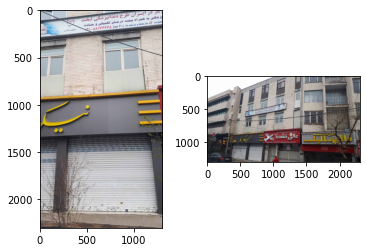

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math


def imshow(*srcs):
    plt.close()
    fig, ax = plt.subplots(ncols=len(srcs))
    for i, src in enumerate(srcs):
        t = (src - src.min()) / (src.max() - src.min())
        if (len(srcs)) > 1:
            ax[i].imshow(t, cmap='gray')
        else:
            ax.imshow(t, cmap='gray')
    plt.show()


img1 = plt.imread('./data/hw1/im03.jpg')
img2 = plt.imread('./data/hw1/im04.jpg')

imshow(img1, img2)


<p style='direction:rtl; text-align: right'>
تابعی برای اعمال تبدیلات خطی روی مجموعه‌ای از نقاط پیاده می‌کنیم. این تابع نقاط ورودی را به فضای تصویری می‌برد، تبدیل را اعمال می‌کند و
سپس به فضای اقلیدسی باز می‌گردد.
</p>


In [2]:
def apply_transform(src_points, mat):
    src_points = np.array(src_points, dtype=np.float64)
    src_points = np.hstack([src_points, np.ones(src_points.shape[0], dtype=np.float64)[:, None]])
    dst_points = np.matmul(mat, src_points.T).T
    return dst_points[:, :2] / (dst_points[:, 2][:, None] + 0.000001)

<p style='direction:rtl; text-align: right'>
حال تابعی برای نرمالایز کردن اعداد پیاده می‌کنیم. این تابع، نقاط را در هر یک از ابعاد آن، ‌جداگانه نرمالایز می‌کند و علاوه بر آن،
ماتریس تبدیل مربوط به نرمالایزیشن را نیز بر می‌گرداند.
</p>

In [3]:
def normalizer_2d(points):
    points = np.array(points, dtype=np.float64)
    mean = np.average(points, axis=0)
    std = np.std(points, axis=0)
    std = np.maximum(std, np.ones_like(std) / 100)
    mat = np.array([[1 / std[0] * math.sqrt(2), 0, -mean[0] / std[0] * math.sqrt(2)],
                    [0, 1 / std[1] * math.sqrt(2), -mean[1] / std[1] * math.sqrt(2)],
                    [0, 0, 1]])
    return apply_transform(points, mat), mat

<p style='direction:rtl; text-align: right'>
در تابع زیر، روش محاسبه هوموگرافی با Normalized DLT را پیاده می‌کنیم که از تجزیه SVD استفاده می‌کند.
</p>

In [4]:
def find_homography_lsq(src_points, dst_points, mask=None, invert=True):
    src_points = np.array(src_points, dtype=np.float64)
    dst_points = np.array(dst_points, dtype=np.float64)
    if mask is None:
        mask = np.ones(src_points.shape[0], dtype=np.bool)
    src_points, t1 = normalizer_2d(src_points)
    dst_points, t2 = normalizer_2d(dst_points)
    mat = np.zeros((2 * src_points.shape[0], 9))
    for i, (pt1, pt2, val) in enumerate(zip(src_points, dst_points, mask)):
        if not val:
            continue
        if invert:
            pt2 = pt2[::-1]
        mat[2 * i] = np.array([-pt1[0], -pt1[1], -1, 0, 0, 0, pt1[0] * pt2[1], pt1[1] * pt2[1], pt2[1]])
        mat[2 * i + 1] = np.array([0, 0, 0, -pt1[0], -pt1[1], -1, pt1[0] * pt2[0], pt1[1] * pt2[0], pt2[0]])
    u, s, vh = np.linalg.svd(mat, full_matrices=True)
    h = vh[-1, :].reshape((3, 3))
    h = np.matmul(h, t1)
    h = np.matmul(np.linalg.inv(t2), h)
    return h

<p style='direction:rtl; text-align: right'>
حال برای کاهش تاثیر داده‌های پرت، روش رنسک را پیاده می‌کنیم که هر بار مجموعه‌ای تصادفی انتخاب می‌کند، مدل Least Squares را به آن
فیت می‌کند و با یک ترشهولد معین برای فاصله نرم۲ نقطه پیش‌بینی شده مدل،
اینلایر‌ها را می‌شمارد و به دنبال مجموعه‌ای می‌گردد که بیشترین اینلایر در آن جای بگیرد.
</p>

In [5]:
def find_homography_ransac(src_points, dst_points,
                           inlier_threshold=5, max_iterations=10000, confidence=0.8, invert=True):
    src_points = np.array(src_points, dtype=np.float64)
    dst_points = np.array(dst_points, dtype=np.float64)

    best_sample_size = 0
    best_sample_inliers = None

    for _it in range(max_iterations):
        if best_sample_size / src_points.shape[0] > confidence:
            break

        sample_idx = np.random.randint(0, src_points.shape[0], 4)
        sample_src = src_points[tuple(sample_idx), :]
        sample_dst = dst_points[tuple(sample_idx), :]

        mat = find_homography_lsq(sample_src, sample_dst, invert=invert)
        predicted_dst = apply_transform(src_points, mat)
        err_vec = np.linalg.norm(predicted_dst - dst_points, axis=1)

        inliers = err_vec < inlier_threshold
        size = np.sum(inliers)
        if size > best_sample_size:
            best_sample_size = size
            best_sample_inliers = inliers
    src_final_points = np.array([p for i, p in enumerate(src_points) if best_sample_inliers[i]], dtype=np.float64)
    dst_final_points = np.array([p for i, p in enumerate(dst_points) if best_sample_inliers[i]], dtype=np.float64)
    return find_homography_lsq(src_final_points, dst_final_points), best_sample_inliers


<p style='direction:rtl; text-align: right'>
حال به مانند سوال قبل، تعدادی corresponding point پیدا می‌کنیم.
</p>


In [6]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

match_ratio_threshold = 0.7
matches = cv.BFMatcher().knnMatch(des1, des2, k=2)
matches = [m1 for m1, m2 in matches if m1.distance < match_ratio_threshold * m2.distance]

<p style='direction:rtl; text-align: right'>
و در نهایت با استفاده از این نقاط به دست آمده، تابع رنسکی که پیاده کردیم را اجرا می‌کنیم و با ماتریس به دست آمده، تصویر را
وارپ می‌کنیم.
برای رنسک، ۵۰۰۰ ایتریشن و خطای ۵ پیکسل را استفاده می‌کنیم. ماتریس هوموگرافی را در ادامه می‌بینید:
</p>

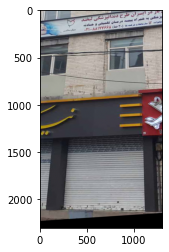

[[-2.14203780e+00 -1.27549821e-01  1.35921656e+03]
 [-3.54533898e-02 -1.32111382e+00  6.57820483e+02]
 [-7.87504165e-05  1.04134052e-04 -5.72790182e-01]]


In [7]:
img1_final_points = np.float64([kp1[m.queryIdx].pt for m in matches])
img2_final_points = np.float64([kp2[m.trainIdx].pt for m in matches])

M, mask = find_homography_ransac(img2_final_points, img1_final_points, max_iterations=5000, inlier_threshold=5)
img2_warped = cv.warpPerspective(img2, M, img1.shape[:2][::-1])

imshow(img2_warped)

print(M)

<p style='direction:rtl; text-align: right'>
می‌بینیم کمی با ماتریس به دست آمده در سوال۳ متفاوت است که به دلیل تصادفی و تقریبی بودن روش رنسک است.
<br>
<br>
همچنین می‌توانید کل تصویر وارپ شده را در زیر ببینید:
</p>


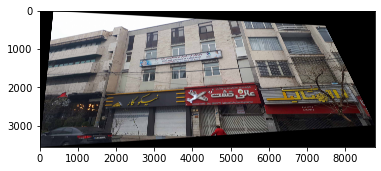

In [8]:
src_points = np.float32([[0, 0], [0, img2.shape[0]], [img2.shape[1], img2.shape[0]], [img2.shape[1], 0]])
predicted_dst = cv.perspectiveTransform(src_points.reshape(-1, 1, 2), M).reshape(src_points.shape)
p_min = np.min(predicted_dst, axis=0)
p_max = np.max(predicted_dst, axis=0)
p_diff = p_max - p_min
M_t = np.array([[1, 0, -p_min[0]], [0, 1, -p_min[1]], [0, 0, 1]])
M_p = np.matmul(M_t, M)
img2_warped_p = cv.warpPerspective(img2, M_p, tuple(p_diff))

imshow(img2_warped_p)
